# Neighborhood Search

In this notebook, we will look at how to apply neighborhood search techniques to solve a scheduling problem. The following code block imports libraries that we will use.

In [1]:
import json
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from tqdm.auto import tqdm

## Neighborhood Search Overview

A neighborhood search procedure is an optimization technique used to find a solution to a problem by iteratively exploring the "neighborhood" of a current "incumbent" solution. The incumbent solution corresponds to the best solution encountered at a current point during the execution of an algorithm. The neighborhood of a solution consists of all possible solutions that can be reached from the incumbent by making a small or local change, i.e., they are "close" to the incumbent solution, where the definition of close depends on the neighborhood structure that is being used.

## Data
We will apply neighborhood search to the Traveling Salesman Problem (TSP). The TSP seeks to identify a tour among a given set of locations that visits each city exactly once, returns to the origin, and minimizes the total travel distance. Even though the TSP is typically solved in the context of logistics, it is a scheduling problem that can be represented as $1/s_{ij}/C_{max}$ using $\alpha / \beta / \gamma$ notation.

The following code block generates data for a TSP instance of a specified size, $n$.

In [2]:
N = 50
locations = [i for i in range(1, N+1)]

np.random.seed(0)

coordinates = pd.DataFrame(
    np.random.uniform(low=0, high=100, size=(N, 2)),
    index=locations,
    columns=['x', 'y'],
)
coordinate_dicts = coordinates.to_dict(orient='index')

d = pd.DataFrame(
    euclidean_distances(coordinates, coordinates),
    index=locations,
    columns=locations,
).reset_index().rename(
    columns={'index': 'start'}
).melt(
    id_vars=['start']
).rename(
    columns={
        'variable': 'end',
        'value': 'distance',
    }
).set_index(
    ['start', 'end']
)['distance'].to_dict()

The following code block defines a function we can use to plot a TSP instance and a tour (if provided)

In [3]:
def generate_plot(
    tour_list: list = [],
    label_locations: bool = True,
):
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    coordinates.plot(
        kind='scatter',
        x='x',
        y='y',
        edgecolor='k',
        ax=ax,
    )
    
    ax.spines[['right', 'top']].set_visible(False)
    if label_locations:
        for customer, coordinate_dict in coordinate_dicts.items():
            ax.annotate(customer, (coordinate_dict['x']*1.02, coordinate_dict['y']*1.02))
    
    if tour_list:
        x_list, y_list = [], []
        for location_idx, location in enumerate(tour_list[:-1], 0):
            x_list.append([coordinate_dicts[location]['x'], coordinate_dicts[tour_list[location_idx+1]]['x']])
            y_list.append([coordinate_dicts[location]['y'], coordinate_dicts[tour_list[location_idx+1]]['y']])
        x_list.append([coordinate_dicts[tour_list[-1]]['x'], coordinate_dicts[tour_list[0]]['x']])
        y_list.append([coordinate_dicts[tour_list[-1]]['y'], coordinate_dicts[tour_list[0]]['y']])
        
        ax.plot(
            x_list,
            y_list,
            color='steelblue',
        )
    
    plt.show()

The following code block demonstrates the plotting function (no tour provided)

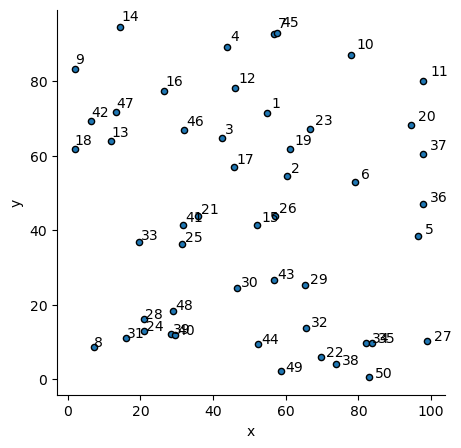

In [4]:
generate_plot()

The following code block demonstrates the plotting function if a tour is provided

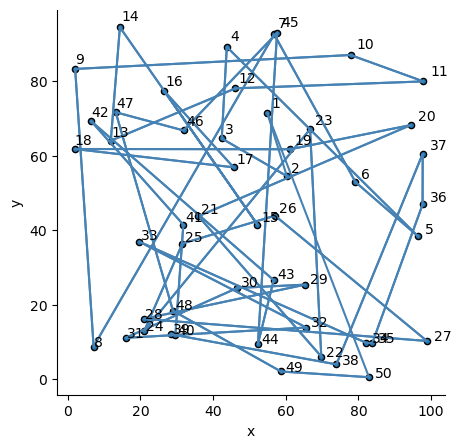

In [5]:
heuristic_solution = [i for i in locations]

generate_plot(tour_list=heuristic_solution)

## Functions for generating neighbors

We will consider three different neighborhood structures:
1. Adjacent Pairwise Interchange (API) - given sequence of elements, an adjacent pairwise interchange swaps two consecutive elements. There are $n-1$ possible adjacent pairwise interchanges for a sequence of length $n-1$.
2. Pairwise Interchange (PI) - given sequence of elements, a pairwise interchange involves selecting any two distinct elements and swapping their positions. There are $\frac{n(n-1)}{2}$ possible pairwise interchanges for a sequence of length $n$.
3. Subsequence Reversal (SSR) - given sequence of elements, a contiguous subsequence (a consecutive subset of elements) is reversed. There are $\frac{n(n-1)}{2}$ possible subsequence reversals for a sequence of length $n$.

The following code block defines functions to generate API, PI, and SSR neighbors. The functions are named `get_API_neighbor`, `get_PI_neighbor`, and `get_SSR_neighbor`, respectively.

In [6]:
def get_API_neighbor(schedule_list):

    neighbor_list = list(schedule_list)
    valid_indices = range(len(neighbor_list)-1)
    idx1 = random.choice(valid_indices)
    idx2 = idx1 + 1

    neighbor_list[idx2], neighbor_list[idx1] = neighbor_list[idx1], neighbor_list[idx2]

    return neighbor_list


def get_PI_neighbor(schedule_list):

    neighbor_list = list(schedule_list)
    valid_indices = list(range(len(neighbor_list)))
    idx1, idx2 = random.choices(valid_indices, k=2)

    neighbor_list[idx2], neighbor_list[idx1] = neighbor_list[idx1], neighbor_list[idx2]

    return neighbor_list


def get_SSR_neighbor(schedule_list):

    neighbor_list = list(schedule_list)
    valid_indices = list(range(len(neighbor_list)))
    idx1, idx2 = random.choices(valid_indices, k=2)
    
    if idx1 < idx2:
        neighbor_list[idx1:idx2+1] = neighbor_list[idx1:idx2+1][::-1]
    else:
        neighbor_list[idx2:idx1+1] = neighbor_list[idx2:idx1+1][::-1]

    return neighbor_list

## Function for computing objective (total distance)

The following code block defines a function to compute the total distance for a tour

In [7]:
def compute_total_distance(schedule_list):

    total_distance = 0
    for start_idx in range(len(schedule_list)-1):
        start_location = schedule_list[start_idx]
        end_location = schedule_list[start_idx + 1]
        total_distance += d[start_location, end_location]
    
    # handle return to origin
    start_location = schedule_list[-1]
    end_location = schedule_list[0]
    total_distance += d[start_location, end_location]
    
    return total_distance

## Neighborhood Search Implementation

The following code block implements the neighborhood search with a random selection criteria for keeping an improving solution.

At a high level, the procedure:
1) Is initialized with a solution that can be chosen randomly or through the use of a construction heuristic.
2) Evaluates the quality of the initial solution and saves it as the incumbent solution.
3) Generates neighbors of the incumbent solution based on the selected neighborhood structure.
4) Evaluates the quality of neighbor solutions, saving them as the incumbent solution if the quality of the neighbor is better than the incumbent. **Note** that the code I have written includes another random selection probability that can result in discarding some improving solutions. Mechanisms such as this are sometimes used to prevent local optima or increase diversity. I am simply including it so that you understand such mechanisms exist.
5) Continue the process until a terminating criterion is met, such as a maximum number of iterations or a time limit.

The implementation in the following cell:
- uses an initial solution that simply visits the locations in order or the location index,
- uses a SSR neighborhood,
- terminates after 3,000 non-improving iterations, and
- retains improving neighbors 95% of the time.

A plot is produced that shows the progress of the neighborhood search procedure as the number of executed iterations increases.

 - incumbent_objective = 618.698


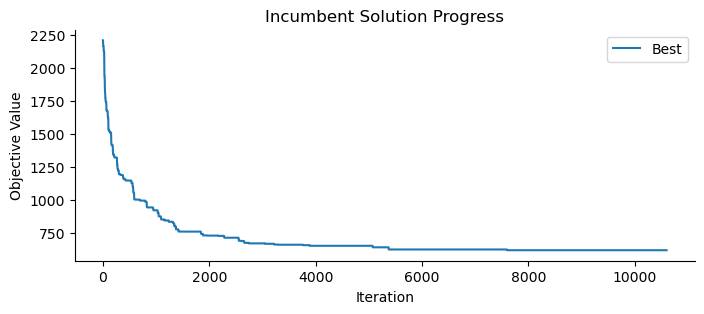

In [8]:
random.seed(42)

selection_probability = 0.95
max_ni_iterations = 3_000
neighbor_function = get_SSR_neighbor
objective_function = compute_total_distance

incumbent_solution = list(locations)
incumbent_objective = objective_function(incumbent_solution)

iteration = 0
count = 0
progress = []
while iteration < max_ni_iterations:
    iteration += 1
    count += 1
    
    neighbor = neighbor_function(incumbent_solution)
    neighbor_objective = objective_function(neighbor)
    if neighbor_objective < incumbent_objective:
        if random.random() < selection_probability:
            incumbent_solution = neighbor
            incumbent_objective = neighbor_objective
            iteration = 0
    progress.append({'Iteration': count, 'Best': incumbent_objective})

print(f' - {incumbent_objective = :.3f}')

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

progress_df = pd.DataFrame(progress)
progress_df.plot(
    x='Iteration',
    y='Best',
    ax=ax,
)
ax.set_title('Incumbent Solution Progress')
ax.set_ylabel('Objective Value')
ax.spines[['right', 'top']].set_visible(False)
plt.show()

The following code block plots the best tour

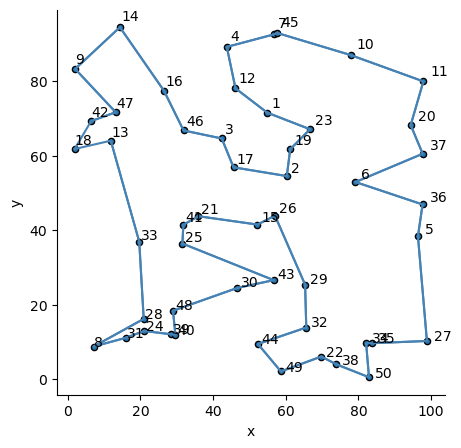

In [9]:
generate_plot(incumbent_solution)

## Experiment

The following code block defines a function for the previously demonstrated neighborhood search procedure.

In [10]:
def run_neighborhood_search(
    starting_solution,
    neighbor_function,
    objective_function,
    max_non_improving_iterations=100,
    improving_solution_retention_probability=1.00,
    random_state=None,
):
    if isinstance(random_state, int):
        random.seed(random_state)
    
    incumbent_solution = list(starting_solution)
    incumbent_objective = objective_function(incumbent_solution)
    
    iteration = 0
    while iteration < max_non_improving_iterations:
        iteration += 1
        
        neighbor = neighbor_function(incumbent_solution)
        neighbor_objective = objective_function(neighbor)
        if neighbor_objective < incumbent_objective:
            if random.random() < improving_solution_retention_probability:
                incumbent_solution = neighbor
                incumbent_objective = neighbor_objective
                iteration = 0

    return incumbent_solution, incumbent_objective

The following function defines an experiment that will solve the problem using neighborhood search for:
- Three different neighborhood structures: API, PI, SSR,
- Three different termination criterion: max iterations of 100, 1,000, and 3,000,
- Three different solution retention probabilities: 0.90, 0.95, 0.99, and 1.00.

The experiment solves each of these combinations with ten different random seed values. The objective function for the final incumbent solution for each of these runs is saved and used to create a `pandas DataFrame` named `experiment_results`. The elapsed run time is also saved.

In [11]:
neighborhood_functions = {
    'API': get_API_neighbor,
    'PI': get_PI_neighbor,
    'SSR': get_SSR_neighbor,
}

experiment_results = []
for neighborhood in tqdm(neighborhood_functions, 'Iterating on neighborhoods'):
    neighborhood_function = neighborhood_functions[neighborhood]
    for seed in range(10):
        for max_iterations in [100, 1000, 3000]:
            for retention_probability in [0.90, 0.95, 0.99, 1.0]:

                start_time = time.time()
                starting_solution = list(locations)
                
                best_tour, best_objective = run_neighborhood_search(
                    starting_solution,
                    neighbor_function=neighborhood_function,
                    objective_function=compute_total_distance,
                    max_non_improving_iterations=max_iterations,
                    improving_solution_retention_probability=retention_probability,
                    random_state=seed,
                )
                
                end_time = time.time()
                elapsed_time = round(end_time - start_time, 2)
    
                experiment_results.append({
                    'neighborhood': neighborhood,
                    'seed': seed,
                    'max_iterations': max_iterations,
                    'retention_probability': retention_probability,
                    'best_objective': best_objective,
                    'elapsed_time': elapsed_time,
                    
                })

experiment_results = pd.DataFrame(experiment_results)
experiment_results.head()

Iterating on neighborhoods:   0%|          | 0/3 [00:00<?, ?it/s]

,neighborhood,seed,max_iterations,retention_probability,best_objective,elapsed_time
0,API,0,100,0.90,1768.840400,0.0
1,API,0,100,0.95,1776.648792,0.0
2,API,0,100,0.99,1776.648792,0.0
3,API,0,100,1.00,1776.648792,0.0
4,API,0,1000,0.90,1768.840400,0.0


The following code block plots 95% confidence intervals for the mean objective of the final incumbent solution as the neighborhood structure, max iterations, and solution retention probability vary.

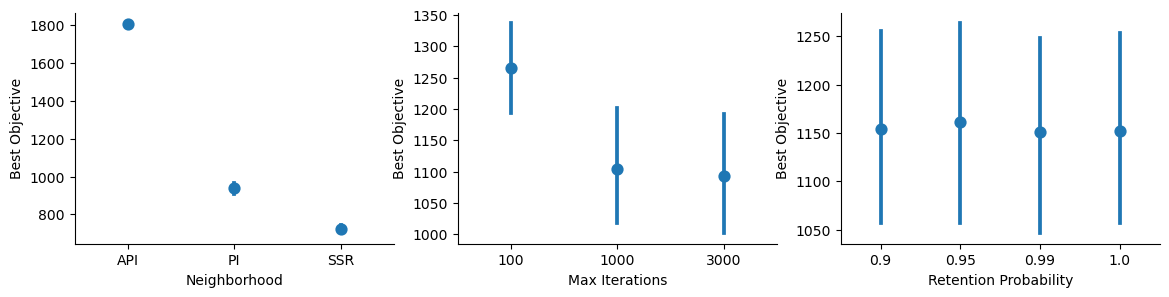

In [12]:
mosaic = [
    ['neighborhood', 'max_iterations', 'retention_probability']
]

metric = 'best_objective'

fig, ax = plt.subplot_mosaic(mosaic, figsize=(14, 3))

for factor in mosaic[0]:
    cax = ax[factor]

    sns.pointplot(
        experiment_results,
        x=factor,
        y=metric,
        linestyle='none',
        ax=cax
    )
    cax.spines[['right', 'top']].set_visible(False)
    cax.set_xlabel(factor.replace('_',' ').title())
    cax.set_ylabel(metric.replace('_',' ').title())

plt.show()

The following code block plots 95% confidence intervals for the mean elapsed time (in seconds) for the procedure as the neighborhood structure, max iterations, and solution retention probability vary.

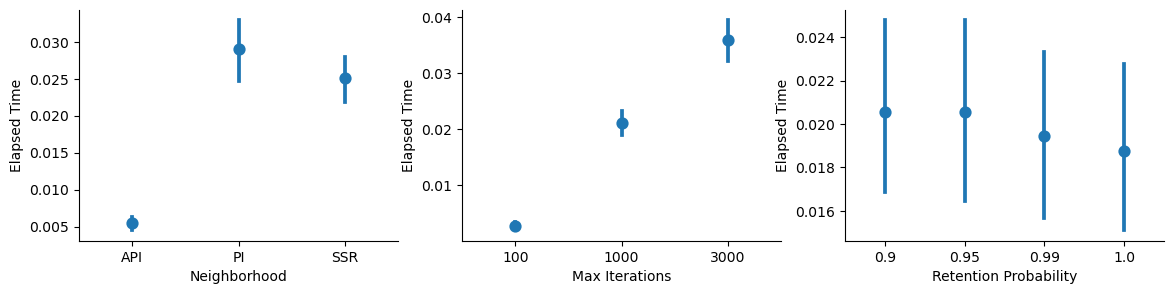

In [13]:
mosaic = [
    ['neighborhood', 'max_iterations', 'retention_probability']
]

metric = 'elapsed_time'

fig, ax = plt.subplot_mosaic(mosaic, figsize=(14, 3))

for factor in mosaic[0]:
    cax = ax[factor]

    sns.pointplot(
        experiment_results,
        x=factor,
        y=metric,
        linestyle='none',
        ax=cax
    )
    cax.spines[['right', 'top']].set_visible(False)
    cax.set_xlabel(factor.replace('_',' ').title())
    cax.set_ylabel(metric.replace('_',' ').title())

plt.show()